# **Financial Headlines Sentiment Analysis**
# Author: Jakov Vodanović

# Loading data and essential libraries.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If you wish to do this yourself, you will have to change the path.

In [2]:
%cd /content/drive/MyDrive/Arhitekture neuronskih mreža/Projekt

/content/drive/MyDrive/Arhitekture neuronskih mreža/Projekt


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('archive/all-data.csv', encoding='latin-1')
print(df.head())
print("Total positive:", len(df[df['sentiment'] == 'positive']))
print("Total negative:", len(df[df['sentiment'] == 'negative']))
print("Total neutral:", len(df[df['sentiment'] == 'neutral']))

  sentiment                                           headline
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...
Total positive: 1363
Total negative: 604
Total neutral: 2879


# Data processing.

In [5]:
# tokenize words in headlines
headlines = df['headline']
print(type(headlines))
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(headlines)
print(len(tokenizer.word_index)) # 10000 is a relatively small amount of words so we wont set a cap here

<class 'pandas.core.series.Series'>
10122


In [6]:
sequences = tokenizer.texts_to_sequences(headlines)

In [7]:
# pad sequences to equal length
lengths = map(lambda x: len(x), sequences)
max_length = np.max(list(lengths))
print(f"Max length: {max_length}")
sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding="post", maxlen=max_length)
print(sequences.shape)
# check randomly to ensure they are all padded to the correct length
print(len(sequences[66]))
print(len(sequences[77]))

Max length: 71
(4846, 71)
71
71


It appears that all are of the same length, and the padding was successful.

In [8]:
# get sentiments (labels), tensorflow requires them to be integers, so need to map them
sentiment_mapping = {
    "negative" : 0,
    "positive" : 1,
    "neutral" : 2
}
y = df['sentiment'].replace(sentiment_mapping)

x_train, x_test, y_train, y_test = train_test_split(sequences, y, train_size = 0.7, shuffle = True, random_state = 1)

In [9]:
print(x_train)
print(list(y_train))

[[5442  510   16 ...    0    0    0]
 [  22 1628    4 ...    0    0    0]
 [1141  936  136 ...    0    0    0]
 ...
 [   1  419   16 ...    0    0    0]
 [2586  123 3247 ...    0    0    0]
 [  30  615  555 ...    0    0    0]]
[1, 0, 2, 2, 1, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 0, 2, 1, 1, 1, 2, 2, 0, 2, 2, 2, 1, 0, 1, 2, 1, 0, 0, 0, 1, 1, 2, 2, 1, 0, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 0, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 0, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 0, 2, 1, 2, 0, 2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 0, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 0, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 

First, let's convert words into different integers and encode our sentences based on these integers. In this encoding, there are no specific rules, just encoding. The primary layer of the RNN, the Embedding layer, is crucial. It takes a sequence of sentences with encoded words as input (we need to pad with zeros and/or truncate to ensure uniform size), and it outputs a vector representing a word for a given vector size. Why is this much better than the one-hot encoder used in categorical encoding? Firstly, the one-hot vector would be over 10,000 in length in this case, with only one '1' and the rest '0's, making it impractical. Secondly, all words are equally distant from each other. Training the Embedding allows us to encode words so that words frequently appearing together will be closer in Euclidean distance.

# RNN Basics

Let's illustrate a simple RNN model, train it, and observe the results.

<img src='https://drive.google.com/uc?id=1cCqTXurPJYd7BwyIpfrsOo_1FU0kxx0U' width='90%'>

<br><br>

$$h_t = f_W(h_{t-1}, x_t)$$

>The same function $f$ and parameters $W$ are used at each step

1. input at step $t$:
 - $x_t$
2. hidden state update:
 - $h_t = \tanh(W_{hh}^Th_{t-1} + W_{xh}^Tx_t + b_h)$
3. output:
 - $\hat{y}t=W^T{hy}h_t + b_y$

So, we update all these weights during training.


Before training the baseline model, we need to discuss all the parameters. Firstly, in the Embedding layer, we need to set the size of the vector representing words. In one-hot encoding, this would be the size of the vocabulary, but now we want to reduce it. Of course, a larger vector will better represent a word, but it will also slow down the network training. There is no fixed number that is good for choosing the dimension for any dataset. Considering that Word2Vec uses 300 dimensions for a much larger vocabulary in Google News, it doesn't make sense to go beyond 300. We will try 50 and 100 dimensions and compare effectiveness defined as: accuracy - 0.001*seconds.

We will use ADAM to avoid getting stuck in a local minimum, which is a common issue with other optimizers like SGD.

# 50-dimensional vector.

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=10123,
                                    output_dim=50,
                                    input_length=x_train.shape[1]))
model.add(tf.keras.layers.SimpleRNN(50))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [11]:
start_time = time.time()

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
)


end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

Epoch 1/10
85/85 [==============================] - 22s 209ms/step - loss: 0.9247 - accuracy: 0.5997 - val_loss: 0.9744 - val_accuracy: 0.5700
Epoch 2/10
85/85 [==============================] - 12s 145ms/step - loss: 0.8795 - accuracy: 0.6130 - val_loss: 0.9473 - val_accuracy: 0.5758
Epoch 3/10
85/85 [==============================] - 9s 112ms/step - loss: 0.6927 - accuracy: 0.7228 - val_loss: 1.0626 - val_accuracy: 0.4978
Epoch 4/10
85/85 [==============================] - 9s 97ms/step - loss: 0.4173 - accuracy: 0.8481 - val_loss: 1.2424 - val_accuracy: 0.4801
Epoch 5/10
85/85 [==============================] - 8s 99ms/step - loss: 0.2442 - accuracy: 0.9233 - val_loss: 1.6065 - val_accuracy: 0.5007
Epoch 6/10
85/85 [==============================] - 8s 94ms/step - loss: 0.1900 - accuracy: 0.9440 - val_loss: 1.7646 - val_accuracy: 0.4860
Epoch 7/10
85/85 [==============================] - 9s 102ms/step - loss: 0.1160 - accuracy: 0.9631 - val_loss: 1.9437 - val_accuracy: 0.4551
Epoch 8

In [12]:
_, acc = model.evaluate(x_test, y_test)

46/46 [==============================] - 0s 8ms/step - loss: 1.9680 - accuracy: 0.5172


In [13]:
acc - 0.001*elapsed_time

0.3726280908584595

In [16]:
pred = [np.argmax(pred) for pred in model.predict(x_test)]

46/46 [==============================] - 1s 17ms/step


In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

<Axes: >

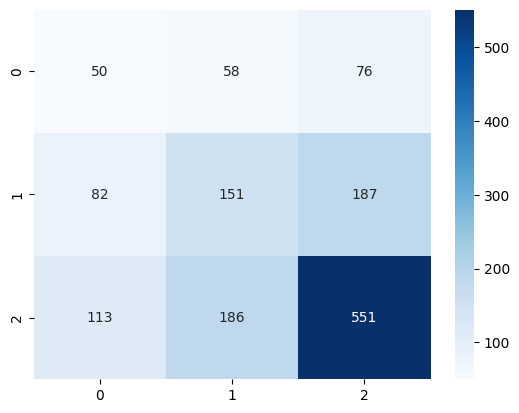

In [18]:
sns.heatmap(confusion_matrix(y_test, pred), annot=True, cmap='Blues', fmt='g')

In [19]:
def find_incorrect_indices(model, x_test, y_test):
  x = model.predict(x_test)
  pred = [np.argmax(pred) for pred in x]
  pred = np.array(pred)
  y_test1 = np.array(y_test)
  l = []
  for i in range(len(pred)):
    if(pred[i] != y_test1[i]):
      l.append(i)
  l = np.array(l)
  return l

In [20]:
def sequence_to_text(index):
  print(tokenizer.sequences_to_texts([x_test[index]]))
  sentiment_mapping = {
    0 : "negative",
    1 : "positive",
    2 : "neutral"
    }
  print(f"True sentiment: {sentiment_mapping[np.array(y_test)[index]]}")
  print(f"Predicted sentiment: {sentiment_mapping[pred[index]]} \n")

In [21]:
l = find_incorrect_indices(model, x_test, y_test)

46/46 [==============================] - 1s 14ms/step


In [22]:
for i in range(5):
  sequence_to_text(l[i])

['aspocomp has repaid its interest bearing liability to standard chartered bank and will use the rest of the consideration to partially repay its interest bearing liabilities in finland and to improve its liquidity']
True sentiment: positive
Predicted sentiment: negative 

['this is bad news for the barbeque season']
True sentiment: negative
Predicted sentiment: neutral 

["of the price kesko 's share is 10 mln euro 15 5 mln and it will recognize a gain of 4 0 mln euro 6 2 mln on the disposal which will be included in the result for the second quarter of 2008"]
True sentiment: positive
Predicted sentiment: neutral 

["30 november 2009 finnish office furniture maker martela oyj hel maras said today that it will make redundant three people and other nine will be laid off permanently from the company 's office staff and factory workers"]
True sentiment: negative
Predicted sentiment: neutral 

["'s outokumpu technology business will begin trading on the nordic exchange in helsinki starting

In [23]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.20      0.27      0.23       184
           1       0.38      0.36      0.37       420
           2       0.68      0.65      0.66       850

    accuracy                           0.52      1454
   macro avg       0.42      0.43      0.42      1454
weighted avg       0.53      0.52      0.52      1454



As we can see, the accuracy on the validation is falling off a cliff. Let's implement early stopping to save time.

# Early stopping

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=10123,
                                    output_dim=50,
                                    input_length=x_train.shape[1]))
model.add(tf.keras.layers.SimpleRNN(50))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# zaustavljamo treniranje mreže ako 3 uzastopne epohe nema poboljšanja gubitka na skupu za validaciju
callback_ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[callback_ES]
)


end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

Epoch 1/10
85/85 [==============================] - 15s 146ms/step - loss: 0.8783 - accuracy: 0.6159 - val_loss: 0.8674 - val_accuracy: 0.5817
Epoch 2/10
85/85 [==============================] - 9s 109ms/step - loss: 0.6248 - accuracy: 0.7564 - val_loss: 0.9022 - val_accuracy: 0.5965
Epoch 3/10
85/85 [==============================] - 11s 128ms/step - loss: 0.4807 - accuracy: 0.8120 - val_loss: 1.0489 - val_accuracy: 0.6421
Epoch 4/10
85/85 [==============================] - 7s 77ms/step - loss: 0.3675 - accuracy: 0.8669 - val_loss: 1.0735 - val_accuracy: 0.6377
Elapsed time:  41.82280445098877


In [ ]:
_, acc = model.evaluate(x_test, y_test)

46/46 [==============================] - 0s 7ms/step - loss: 0.8350 - accuracy: 0.6059


In [ ]:
acc - 0.001*elapsed_time

0.5640919075012207

According to our effectiveness measure, the early stopping model is much better.

# 100-dimensional vector

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=10123,
                                    output_dim=100,
                                    input_length=x_train.shape[1]))
model.add(tf.keras.layers.SimpleRNN(100))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# zaustavljamo treniranje mreže ako 3 uzastopne epohe nema poboljšanja gubitka na skupu za validaciju
callback_ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[callback_ES]
)


end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

Epoch 1/10
85/85 [==============================] - 15s 153ms/step - loss: 0.9225 - accuracy: 0.6049 - val_loss: 0.9857 - val_accuracy: 0.5700
Epoch 2/10
85/85 [==============================] - 10s 121ms/step - loss: 0.9227 - accuracy: 0.6052 - val_loss: 0.9623 - val_accuracy: 0.5714
Epoch 3/10
85/85 [==============================] - 8s 93ms/step - loss: 0.9226 - accuracy: 0.5916 - val_loss: 0.9547 - val_accuracy: 0.5700
Epoch 4/10
85/85 [==============================] - 7s 84ms/step - loss: 0.9025 - accuracy: 0.5905 - val_loss: 1.0103 - val_accuracy: 0.5700
Epoch 5/10
85/85 [==============================] - 7s 88ms/step - loss: 0.9103 - accuracy: 0.5986 - val_loss: 0.9732 - val_accuracy: 0.5700
Epoch 6/10
85/85 [==============================] - 8s 90ms/step - loss: 0.8448 - accuracy: 0.6439 - val_loss: 0.9918 - val_accuracy: 0.5331
Elapsed time:  55.365785360336304


In [ ]:
_, acc = model.evaluate(x_test, y_test)

46/46 [==============================] - 0s 7ms/step - loss: 0.9255 - accuracy: 0.5846


In [ ]:
acc - 0.001*elapsed_time

0.5292284643650055

As we can see in this attempt, the 100-dimensional vector yielded worse results. Therefore, I conclude that the difference is not significant, and we can opt for the 50-dimensional vector. It's likely that we could even use a vector of smaller dimensions due to the small vocabulary.

We notice that these accuracies hover around 59 percent. At first glance, it may not seem like a terrible result. However, a trivial network that only predicts "neutral" would give us 59 percent accuracy since we have approximately 59 percent neutral news in the data. Therefore, we definitely want higher accuracy than this.

# GRU

Our model is learning very slowly, and it seems that after a few iterations it's not improving, which leads to early stopping. We used a simple RNN, so we likely encountered the issue of vanishing gradients. The vanishing gradient problem arises because of the way weights are computed in the network: in later iterations, "older" weights stop training ("backpropagation" weakly updates older weights due to very small derivatives – the issue arises if using sigmoid or hyperbolic tangent activation functions). Let's change the model to a GRU now.

What is a GRU?

<br>

<img src='https://miro.medium.com/v2/resize:fit:720/format:webp/1*6eNTqLzQ08AABo-STFNiBw.png' width='90%'>

<br>


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=10123,
                                    output_dim=50,
                                    input_length=x_train.shape[1]))
model.add(tf.keras.layers.GRU(256, activation='tanh', return_sequences=True))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

It's important to emphasize the use of "return_sequences=True," which allows us to "return" a sequence of all hidden states (these are just the outputs in the sequence).

In [ ]:
# zaustavljamo treniranje mreže ako 3 uzastopne epohe nema poboljšanja gubitka na skupu za validaciju
callback_ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[callback_ES]
)


end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

Epoch 1/10
85/85 [==============================] - 15s 133ms/step - loss: 0.8511 - accuracy: 0.6273 - val_loss: 0.8041 - val_accuracy: 0.6377
Epoch 2/10
85/85 [==============================] - 8s 93ms/step - loss: 0.5468 - accuracy: 0.7737 - val_loss: 0.7702 - val_accuracy: 0.6672
Epoch 3/10
85/85 [==============================] - 4s 50ms/step - loss: 0.2370 - accuracy: 0.9090 - val_loss: 1.0677 - val_accuracy: 0.6804
Epoch 4/10
85/85 [==============================] - 3s 30ms/step - loss: 0.0600 - accuracy: 0.9827 - val_loss: 1.3067 - val_accuracy: 0.6745
Epoch 5/10
85/85 [==============================] - 3s 37ms/step - loss: 0.0312 - accuracy: 0.9923 - val_loss: 1.2007 - val_accuracy: 0.6922
Elapsed time:  33.35904788970947


In [ ]:
_, acc = model.evaluate(x_test, y_test)

46/46 [==============================] - 0s 7ms/step - loss: 0.6875 - accuracy: 0.7125


In [ ]:
acc - 0.001*elapsed_time

0.6791581540107727

As we can see, these are significantly better results. Let's check if it would be better without early stopping.

# GRU without early stopping

In [50]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=10123,
                                    output_dim=50,
                                    input_length=x_train.shape[1]))
model.add(tf.keras.layers.GRU(256, activation='tanh', return_sequences=True))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [51]:
start_time = time.time()

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
)


end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

Epoch 1/10
85/85 [==============================] - 15s 156ms/step - loss: 0.8500 - accuracy: 0.6358 - val_loss: 0.8236 - val_accuracy: 0.6392
Epoch 2/10
85/85 [==============================] - 4s 45ms/step - loss: 0.5495 - accuracy: 0.7667 - val_loss: 0.8023 - val_accuracy: 0.6510
Epoch 3/10
85/85 [==============================] - 3s 39ms/step - loss: 0.2669 - accuracy: 0.9020 - val_loss: 0.8780 - val_accuracy: 0.6878
Epoch 4/10
85/85 [==============================] - 3s 30ms/step - loss: 0.0778 - accuracy: 0.9801 - val_loss: 1.1419 - val_accuracy: 0.7010
Epoch 5/10
85/85 [==============================] - 2s 22ms/step - loss: 0.0364 - accuracy: 0.9915 - val_loss: 1.2545 - val_accuracy: 0.6789
Epoch 6/10
85/85 [==============================] - 2s 25ms/step - loss: 0.0206 - accuracy: 0.9959 - val_loss: 1.3548 - val_accuracy: 0.7113
Epoch 7/10
85/85 [==============================] - 1s 17ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 1.6991 - val_accuracy: 0.7143
Epoch 8/10


In [52]:
_, acc = model.evaluate(x_test, y_test)

46/46 [==============================] - 0s 6ms/step - loss: 1.5450 - accuracy: 0.7380


In [53]:
acc - 0.001*elapsed_time

0.7030475754737854

The result is better when we removed early stopping.

46/46 [==============================] - 1s 4ms/step


<Axes: >

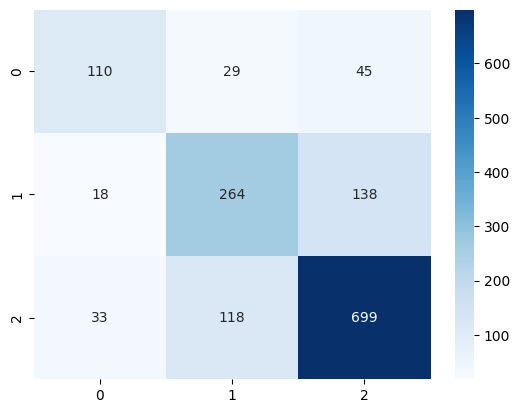

In [54]:
pred = [np.argmax(pred) for pred in model.predict(x_test)]
sns.heatmap(confusion_matrix(y_test, pred), annot=True, cmap='Blues', fmt='g')

In [55]:
l = find_incorrect_indices(model, x_test, y_test)
for i in range(5):
  sequence_to_text(l[i])

46/46 [==============================] - 0s 5ms/step
["the pilot project proved that rifd technology is ideal for our purposes '' comments olli saarinen material handling supervisor at yara"]
True sentiment: positive
Predicted sentiment: negative 

['aspocomp has repaid its interest bearing liability to standard chartered bank and will use the rest of the consideration to partially repay its interest bearing liabilities in finland and to improve its liquidity']
True sentiment: positive
Predicted sentiment: neutral 

['this is bad news for the barbeque season']
True sentiment: negative
Predicted sentiment: neutral 

['finnish silicon wafer technology company okmetic oyj omx helsinki okm1v reported on thursday 7 august an operating profit of eur5 3 m for the period january june 2008 up from eur3 3 m in the corresponding period in 2007']
True sentiment: positive
Predicted sentiment: neutral 

["of the price kesko 's share is 10 mln euro 15 5 mln and it will recognize a gain of 4 0 mln eur

In [56]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.68      0.60      0.64       184
           1       0.64      0.63      0.64       420
           2       0.79      0.82      0.81       850

    accuracy                           0.74      1454
   macro avg       0.71      0.68      0.69      1454
weighted avg       0.74      0.74      0.74      1454



# LSTM

Let's now try with an LSTM. First, let's look at the structure of an LSTM.

<br>

<img src='https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png' width='90%'>

<br>

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=10123,
                                    output_dim=50,
                                    input_length=x_train.shape[1]))
model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
start_time = time.time()

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
)


end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

Epoch 1/10
85/85 [==============================] - 18s 178ms/step - loss: 0.8502 - accuracy: 0.6299 - val_loss: 0.8337 - val_accuracy: 0.6436
Epoch 2/10
85/85 [==============================] - 5s 59ms/step - loss: 0.5680 - accuracy: 0.7663 - val_loss: 0.8172 - val_accuracy: 0.6215
Epoch 3/10
85/85 [==============================] - 5s 63ms/step - loss: 0.3090 - accuracy: 0.8765 - val_loss: 0.8645 - val_accuracy: 0.6951
Epoch 4/10
85/85 [==============================] - 3s 31ms/step - loss: 0.1043 - accuracy: 0.9606 - val_loss: 1.1920 - val_accuracy: 0.6951
Epoch 5/10
85/85 [==============================] - 3s 31ms/step - loss: 0.0436 - accuracy: 0.9871 - val_loss: 1.2984 - val_accuracy: 0.6627
Epoch 6/10
85/85 [==============================] - 1s 18ms/step - loss: 0.0269 - accuracy: 0.9915 - val_loss: 1.4755 - val_accuracy: 0.6760
Epoch 7/10
85/85 [==============================] - 1s 15ms/step - loss: 0.0267 - accuracy: 0.9937 - val_loss: 1.5564 - val_accuracy: 0.6966
Epoch 8/10


In [ ]:
_, acc = model.evaluate(x_test, y_test)

46/46 [==============================] - 0s 6ms/step - loss: 1.9230 - accuracy: 0.7345


In [ ]:
acc - 0.001*elapsed_time

0.6941541800498963

It's a bit slower than GRU and the results are similar.

# Bidirectional LSTM

<img src='https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-25_at_8.54.27_PM.png
' width='90%'>

<br>

It improves the context of the sentence because we know what happened before and after a given word.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=10123,
                                    output_dim=50,
                                    input_length=x_train.shape[1]))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
start_time = time.time()

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
)


end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

Epoch 1/10
85/85 [==============================] - 11s 88ms/step - loss: 0.8590 - accuracy: 0.6285 - val_loss: 0.8447 - val_accuracy: 0.6451
Epoch 2/10
85/85 [==============================] - 5s 63ms/step - loss: 0.5686 - accuracy: 0.7685 - val_loss: 0.7884 - val_accuracy: 0.6672
Epoch 3/10
85/85 [==============================] - 3s 36ms/step - loss: 0.2446 - accuracy: 0.9101 - val_loss: 0.8609 - val_accuracy: 0.7128
Epoch 4/10
85/85 [==============================] - 3s 36ms/step - loss: 0.0777 - accuracy: 0.9779 - val_loss: 1.1071 - val_accuracy: 0.7158
Epoch 5/10
85/85 [==============================] - 2s 19ms/step - loss: 0.0474 - accuracy: 0.9871 - val_loss: 1.1526 - val_accuracy: 0.7010
Epoch 6/10
85/85 [==============================] - 2s 19ms/step - loss: 0.0226 - accuracy: 0.9959 - val_loss: 1.3842 - val_accuracy: 0.6922
Epoch 7/10
85/85 [==============================] - 2s 27ms/step - loss: 0.0109 - accuracy: 0.9985 - val_loss: 1.4793 - val_accuracy: 0.6819
Epoch 8/10
8

In [ ]:
_, acc = model.evaluate(x_test, y_test)

46/46 [==============================] - 0s 4ms/step - loss: 1.4706 - accuracy: 0.7366


In [ ]:
acc - 0.001*elapsed_time

0.704429144859314

There is no significant improvement.

# Bidirectional LSTM with dropout

Apart from implementing dropout, we will also save the model that had the best accuracy on validation and try applying it to the test set.

In [ ]:
checkpoint_LSTM = tf.keras.callbacks.ModelCheckpoint('LSTM_best_val_acc.h5',
                                                     monitor='val_accuracy',
                                                     verbose=1,
                                                     save_best_only=True,
                                                     mode='max')

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=10123,
                                    output_dim=50,
                                    input_length=x_train.shape[1]))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
start_time = time.time()

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[checkpoint_LSTM]
)


end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.8579 - accuracy: 0.6222
Epoch 1: val_accuracy improved from -inf to 0.63623, saving model to LSTM_best_val_acc.h5
85/85 [==============================] - 14s 113ms/step - loss: 0.8579 - accuracy: 0.6222 - val_loss: 0.8056 - val_accuracy: 0.6362
Epoch 2/10
 1/85 [..............................] - ETA: 8s - loss: 0.5613 - accuracy: 0.7500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


82/85 [===========================>..] - ETA: 0s - loss: 0.5616 - accuracy: 0.7683
Epoch 2: val_accuracy improved from 0.63623 to 0.67599, saving model to LSTM_best_val_acc.h5
85/85 [==============================] - 5s 52ms/step - loss: 0.5603 - accuracy: 0.7667 - val_loss: 0.8052 - val_accuracy: 0.6760
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9134
Epoch 3: val_accuracy improved from 0.67599 to 0.68483, saving model to LSTM_best_val_acc.h5
85/85 [==============================] - 3s 37ms/step - loss: 0.2326 - accuracy: 0.9134 - val_loss: 0.9850 - val_accuracy: 0.6848
Epoch 4/10
83/85 [============================>.] - ETA: 0s - loss: 0.0724 - accuracy: 0.9748
Epoch 4: val_accuracy improved from 0.68483 to 0.69072, saving model to LSTM_best_val_acc.h5
85/85 [==============================] - 2s 25ms/step - loss: 0.0715 - accuracy: 0.9753 - val_loss: 1.1538 - val_accuracy: 0.6907
Epoch 5/10
85/85 [==============================] - ETA: 0s 

In [ ]:
best_LSTM = tf.keras.models.load_model('LSTM_best_val_acc.h5')

In [ ]:
_, acc = best_LSTM.evaluate(x_test, y_test)

46/46 [==============================] - 1s 6ms/step - loss: 1.3697 - accuracy: 0.7366


In [ ]:
acc - 0.001*elapsed_time

0.7050313663482666

Dropout did not help.

# LSTM with pre-trained Glove Embedding

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(nb_words=15000)
tokenizer.fit_on_texts(headlines)
sequences = tokenizer.texts_to_sequences(headlines)

word_index = tokenizer.word_index

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


In [ ]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

In [ ]:
glove_model = load_glove_model('glove.6B.100d.txt')

Loading Glove Model
400000 words loaded!


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = glove_model.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=x_train.shape[1],
                            trainable=False)

In [ ]:
model = tf.keras.models.Sequential()
model.add(embedding_layer)
model.add(tf.keras.layers.LSTM(100, return_sequences=True))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
start_time = time.time()

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
)


end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

Epoch 1/10
85/85 [==============================] - 5s 17ms/step - loss: 0.8146 - accuracy: 0.6421 - val_loss: 0.7993 - val_accuracy: 0.6377
Epoch 2/10
85/85 [==============================] - 1s 9ms/step - loss: 0.6418 - accuracy: 0.7206 - val_loss: 0.7082 - val_accuracy: 0.6878
Epoch 3/10
85/85 [==============================] - 1s 8ms/step - loss: 0.5430 - accuracy: 0.7670 - val_loss: 0.7031 - val_accuracy: 0.7143
Epoch 4/10
85/85 [==============================] - 1s 7ms/step - loss: 0.5018 - accuracy: 0.7976 - val_loss: 0.7004 - val_accuracy: 0.7054
Epoch 5/10
85/85 [==============================] - 1s 7ms/step - loss: 0.4347 - accuracy: 0.8223 - val_loss: 0.6788 - val_accuracy: 0.7187
Epoch 6/10
85/85 [==============================] - 1s 7ms/step - loss: 0.3694 - accuracy: 0.8607 - val_loss: 0.7701 - val_accuracy: 0.7187
Epoch 7/10
85/85 [==============================] - 1s 8ms/step - loss: 0.3154 - accuracy: 0.8854 - val_loss: 0.7325 - val_accuracy: 0.7216
Epoch 8/10
85/85 [=

In [ ]:
_, acc = model.evaluate(x_test, y_test)

46/46 [==============================] - 1s 11ms/step - loss: 0.8523 - accuracy: 0.7352


In [ ]:
acc - 0.001*elapsed_time

0.7223700320720673

Training with a pre-trained Embedding was significantly faster because most of the weights in these networks were tied to the Embedding. However, the results are relatively similar.

# GRU without early stopping on balanced data

Let's verify the last factor that could potentially aid us, which is equalizing the number of neutral, positive, and negative data points. Although we will reduce the training dataset, it might lead to improved performance. As observed, the model frequently confuses positive and neutral sentiments, while negative sentiments are generally the most challenging for it.

In [24]:
def balance_array(input_array):
    # find the indices of zeros and ones in the original array
    zeros_indices = np.where(input_array == 0)[0]
    ones_indices = np.where(input_array == 1)[0]
    twos_indices = np.where(input_array == 2)[0]

    # ensure that there are equal numbers of zeros and ones
    min_length = min(len(zeros_indices), len(ones_indices), len(twos_indices))
    zeros_indices = zeros_indices[:min_length]
    ones_indices = ones_indices[:min_length]
    twos_indices = twos_indices[:min_length]

    # combine and shuffle the indices
    combined_indices = np.concatenate([zeros_indices, ones_indices, twos_indices])
    np.random.shuffle(combined_indices)

    return combined_indices

In [25]:
def create_list_from_indices(original_list, indices):
    return [original_list[i] for i in indices]

In [26]:
indices = balance_array(y_train)

In [27]:
y_train_alt = np.array(create_list_from_indices(np.array(y_train), indices))
x_train_alt = np.array(create_list_from_indices(np.array(x_train), indices))

In [28]:
len(np.array(y_train_alt))

1260

In [29]:
len(np.where(np.array(y_train_alt) == 0)[0])

420

In [30]:
len(np.where(np.array(y_train_alt) == 1)[0])

420

In [31]:
len(np.where(np.array(y_train_alt) == 2)[0])

420

We can see that the balancing was well done.

In [32]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=10123,
                                    output_dim=50,
                                    input_length=x_train.shape[1]))
model.add(tf.keras.layers.GRU(256, activation='tanh', return_sequences=True))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [33]:
start_time = time.time()

history = model.fit(
    x_train_alt,
    y_train_alt,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
)


end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

Epoch 1/10
32/32 [==============================] - 8s 189ms/step - loss: 1.0903 - accuracy: 0.3730 - val_loss: 1.0506 - val_accuracy: 0.4405
Epoch 2/10
32/32 [==============================] - 7s 220ms/step - loss: 0.8496 - accuracy: 0.6071 - val_loss: 0.9406 - val_accuracy: 0.5397
Epoch 3/10
32/32 [==============================] - 6s 202ms/step - loss: 0.4395 - accuracy: 0.8125 - val_loss: 1.0547 - val_accuracy: 0.5437
Epoch 4/10
32/32 [==============================] - 3s 77ms/step - loss: 0.1545 - accuracy: 0.9474 - val_loss: 1.5174 - val_accuracy: 0.5516
Epoch 5/10
32/32 [==============================] - 2s 53ms/step - loss: 0.0690 - accuracy: 0.9782 - val_loss: 1.1102 - val_accuracy: 0.5357
Epoch 6/10
32/32 [==============================] - 1s 30ms/step - loss: 0.0650 - accuracy: 0.9881 - val_loss: 1.6507 - val_accuracy: 0.5516
Epoch 7/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0145 - accuracy: 0.9980 - val_loss: 2.0153 - val_accuracy: 0.5437
Epoch 8/10

In [34]:
_, acc = model.evaluate(np.array(x_test), np.array(y_test))

46/46 [==============================] - 0s 6ms/step - loss: 2.0336 - accuracy: 0.5970


In [35]:
acc - 0.001*elapsed_time

0.5650146064758301

Results were not improved, in fact, they are worse.

# Conclusion

In all models, the training set accuracy reached up to 95%, while the validation and test set accuracies were considerably lower. I conclude that increasing the number of epochs wouldn't improve the model's performance; in fact, it might worsen it, indicating a mild case of overfitting.

<br>

The best-performing model was the GRU without early stopping on the original dataset, achieving an accuracy of approximately 73.80% on the test set. How satisfied can we be with this accuracy? Well, it's definitely an improvement over the initial attempts with a simple RNN. However, as observed, none of the various models (which are more complex than the GRU) achieved higher accuracy and mostly hovered around 73-74%. The conclusion of this project is that the dataset is simply too small. Despite trying various architectures, implementing measures to prevent overfitting such as early stopping and dropout, experimenting with pre-trained embeddings that didn't enhance training, and attempting to balance positive, negative, and neutral news, significant success was not achieved.